In [1]:
import vtk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading from file to carry out wave crest positioning post-processing

The function vtp2df sets a pandas dataframe from the output files from the simulation. 

In [2]:
def vtp2df(file_name):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(file_name)
    reader.Update()
    pdata = reader.GetOutput()
    x, y, p, v_x, v_y, b = [], [], [], [], [], []
    for i in range(pdata.GetNumberOfPoints()): 
        x.append(pdata.GetPoint(i)[0])
        y.append(pdata.GetPoint(i)[1])
        p.append(pdata.GetPointData().GetArray('Pressure').GetValue(i))
        v_x.append(pdata.GetPointData().GetArray('Velocity').GetTuple(i)[0])
        v_y.append(pdata.GetPointData().GetArray('Velocity').GetTuple(i)[1])
        #b.append(pdata.GetPointData().GetArray('Boundary').GetValue(i))
    return pd.DataFrame({"x": x, "y": y, "pressure": p, "velocity_x": v_x, "velocity_y": v_y})

## Wave crest tracking
### Wave crest celerity in shallow water


The purpose of the analysis is the monitor the distance covered by a given wave in the simulation and compute the celerity at which it propagates across the domain. The theory from shallow water allow us to have a reference value for the celerity in this cases. 

This method, which after identifying the wave crest estimates celerity using the distance covered in period of time, does not provides a metric that is highly consistent. Yet it is a good first approximation top analyse the problem celerity. For further improvement of the analysis a velocity profile is found to observe the effects of the shear in wave celerity.

No handles with labels found to put in legend.


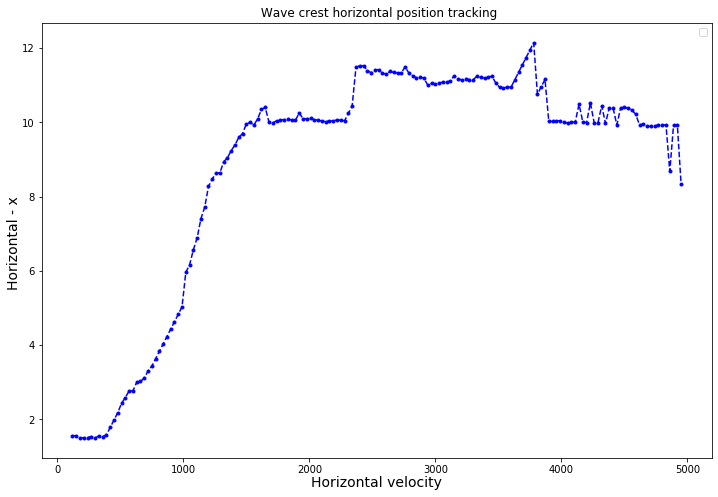

In [8]:
STEP = []
X_CREST = []

for step in range(120, 4980, 30):

    
    STEP.append(step)
    data = vtp2df('test_initial_file_writer00' + str(step) + '.vtp')
    #'test_initial_file_writer001260.vtp'
    data = data[ (data.x >= 0) ]
    data = data[ (data.x <= 20) ]
    data = data[ (data.y >= 0) ]
    data = data[ (data.y <= 9) ]
    data = data[ (data.pressure >= 0) ]


    new_x_max = []
    new_y_max = []


    for elem in data.x:
        new_x_max.append(elem)
    for elem in data.y:
        new_y_max.append(elem)

    new_y_int = []
    for elem in data.y:
        new_y_int.append(int (elem))


    y_int_max = max(new_y_int)
    ###print(y_int_max)


    c = new_y_int.count(y_int_max)

    cnt = 0;
    a=False;
    while a == False:
        if c < 10:
            c = new_y_int.count(y_int_max-cnt) 
        else:
            a = True
        cnt +=1


    #CREST HEIGHT
    y_crest = y_int_max-cnt

    #retreive
    index = 0;
    cnt = 0;
    xs =0;

    for elem in new_y_int:
        if elem == (y_crest):
            xs+= new_x_max[index]
            cnt+=1
        index +=1

    x_crest = xs / cnt     
    X_CREST.append(x_crest)
    ###print(" X crest:", x_crest)
    ###print(" Y crest:", y_crest)

    #max_x = max(new_x_max)
    max_y = max(new_y_max)

    ###print(max_y)
    
#SMOOTHING
for i in range(1,len(STEP)):
    if (  (X_CREST[i]-X_CREST[i-1]) > 1.5 ):
        X_CREST[i] = X_CREST[i-1]+0.2
#plt.plot(STEP, X_CREST, 'b.-')

fig = plt.figure(figsize=(12, 8))
ax1 = plt.axes()

ax1.plot(STEP,X_CREST, "b.--") 
ax1.set_xlabel('Horizontal velocity', fontsize = 14)
ax1.set_ylabel('Horizontal - x ', fontsize = 14)
ax1.set_title(" Wave crest horizontal position tracking")
ax1.grid(False)
ax1.legend(loc='best', fontsize = 10)

## Post processing - celerity



In [54]:
#STEP,X_CREST

STEP[15]
print(STEP[15])
print(STEP[45])
print(X_CREST[15])
print(X_CREST[45])


print(len(X_CREST))
print("....")


diff_xx = 9.69-2.76
time = 30*30*0.0013

cel = diff_xx/time

print(" CELERITY ....")
print(round(cel,2))

570
1470
2.7638498455882363
9.697642669064747
162
....
 CELERITY ....
5.92


## Shallow water wave theory

### Shallow water velocity profiling to observe distribution of velocities close to boundaries

Velocity distributions in shallow water are characterised by the great effect of shear produced by the bottom. This is the cause of the shallow water phenomena called     which induces propagating waves to turn change direction and turn to shore. Observed in curved shores and nearby breakwater structures.


In order to be considered shallow water the wave height H (effective height from bottom to top) to depth D; must be 3:4. If the ratio is smaller we enter in the so called transitional zone. whose definition comes from the fact that is not shallow water by definition yet it cannot be considered deepwater.


#### Deep water vs Shallow water

Deep water wave propagation is modelled by circular orbits in which the energy of the wave is propagated. This circular orbits change as soon as the depth to bottom reduced making them become ellipsoidal and having a particle movement that follows a forward and backwards trend. It is in the very pure shallow waters when the velocity profile shows a greater gradient. And the profile does no longer follow and enxponential increase as the deep waater velocity profiles.

The resulting simplified wave celerity is the so called **c = sqrt (ho * g)**


### Tank shallow water experiment

Considerations:

    1.Considered shallow water dring the initial bit of the simulation not pure shallow water afterwards
    2.ho = 2m. (approx) - conservative as higher ho would result in higher expected celerity
    3.Velocities affected by the error in rough corpuscular distribution (number of particles affect accuracy) 
  

720
750


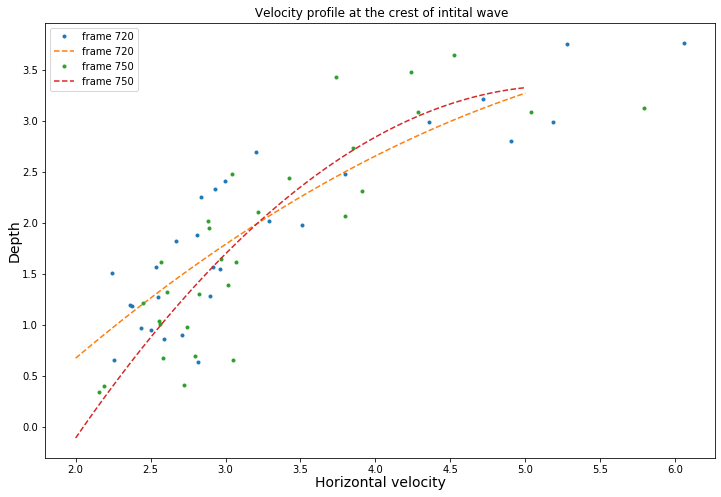

In [55]:
##### -------  FOR LOOP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
center = 6.5
fig = plt.figure(figsize=(12, 8))
ax1 = plt.axes()

for step in range(720, 780, 30):
    print(step)
    data = vtp2df('test_initial_file_writer00' + str(step) + '.vtp')
    data = data[(data.x >= center - 0.2) & (data.x <= center + 0.2)]
    data = data[(data.velocity_x >= 2)]
    data = data[(data.pressure > 0.5)]
    
    #data = csv[['fee', 'time']]
    x = data.velocity_x
    y = data.y
    #fit data to polynomial
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    xp = np.linspace(2,5,100)
    ax1.plot(x,y, "." , xp, p(xp), '--', label = 'frame '+ str(step))
    #ax1.plot( xp, p(xp), '--', label = 'frame '+ str(step))

#ax1.xaxis.set_ticks(np.arange(2, 5, 0.5))  
#ax1.yaxis.set_ticks(np.arange(2, 5, 0.5))  
ax1.set_xlabel('Horizontal velocity', fontsize = 14, labelpad =1)
ax1.set_ylabel('Depth', fontsize = 14, labelpad =1)
ax1.set_title(" Velocity profile at the crest of intital wave")
ax1.grid(False)
ax1.legend(loc='best', fontsize = 10)